<a href="https://colab.research.google.com/github/Codedestructor56/Image_Annotation-model/blob/main/Image_detection%20using%20YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import torch
import os
from torch.utils import data
from PIL import Image
from torchvision import transforms
from collections import defaultdict
import json
import numpy as np

In [68]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=True)

Mounted at /content/gdrive


In [69]:
train_ims=os.listdir('/content/gdrive/MyDrive/train')

In [70]:
os.path.exists('/content/gdrive/MyDrive/_annotations.coco.json')

True

In [71]:
f=open('/content/gdrive/MyDrive/_annotations.coco.json')
print(len(json.loads(f.read())))

5


In [72]:
import json
from collections import defaultdict
image_ids_annotations = defaultdict(list)
file=open('/content/gdrive/MyDrive/_annotations.coco.json','r+')
anns=json.loads(file.read())
for ann in anns['annotations']:
    image_id = ann['image_id'] # Are integers
    image_ids_annotations[image_id].append(ann)
print(image_ids_annotations[165])

[{'id': 205, 'image_id': 165, 'category_id': 30, 'bbox': [95, 14, 34, 44], 'area': 1496, 'segmentation': [], 'iscrowd': 0}, {'id': 206, 'image_id': 165, 'category_id': 30, 'bbox': [488, 88, 30, 43], 'area': 1290, 'segmentation': [], 'iscrowd': 0}, {'id': 207, 'image_id': 165, 'category_id': 30, 'bbox': [70, 482, 86, 105], 'area': 9030, 'segmentation': [], 'iscrowd': 0}]


In [73]:
category_id_annots=defaultdict(list)
for ann in anns['categories']:
    category_id_annots[ann['id']]=ann['name']
print(len(category_id_annots))

31


In [74]:
from pycocotools.coco import COCO

In [75]:
len(list(sorted(COCO('/content/gdrive/MyDrive/_annotations.coco.json').imgs.keys())))

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


3552

In [76]:
class Annot_Im(data.Dataset):
  def __init__(self,im_root,ann_root,transform):
    self.im_root=im_root
    self.ann_root=ann_root
    self.transform=transform
    self.ids=len(list(sorted(COCO('/content/gdrive/MyDrive/_annotations.coco.json').imgs.keys())))
  def __getitem__(self,index):
    image_ids_annotations = defaultdict(list)
    file=open(self.ann_root,'r+')
    anns=json.loads(file.read())
    for ann in anns['annotations']:
        image_id = ann['image_id'] # Are integers
        image_ids_annotations[image_id].append(ann)
    category_id_annots=defaultdict(list)
    for ann in anns['categories']:
        category_id_annots[ann['id']]=ann['name']
    annot_im=anns['images'][index]['file_name']
    if annot_im in os.listdir(self.im_root):
      img=Image.open(os.path.join('/content/gdrive/MyDrive/train',annot_im))
      image_anns = image_ids_annotations[index]
      for i in image_anns:
          bound=i['bbox']
          boxes=[]
          categories=[]
          category=category_id_annots[i['category_id']]
          x=float(bound[0])
          y=float(bound[1])
          w=float(bound[2])
          h=float(bound[3])
          boxes.append([x,y,w,h])
          categories.append(category)
      boxes = torch.as_tensor(boxes, dtype=torch.float32)
    else:
      return None
    annotations={}
    annotations["boxes"] = boxes
    annotations["categories"] = categories
    annotations["image_id"] = image_id
    if self.transform is not None:
      img = self.transform(img)
    return img,annotations
  def __len__(self):
    return self.ids

In [77]:
import torchvision
def get_transform():
  custom_transforms = []
  custom_transforms.append(torchvision.transforms.ToTensor())
  return torchvision.transforms.Compose(custom_transforms)

In [78]:
my_dataset = Annot_Im('/content/gdrive/MyDrive/train','/content/gdrive/MyDrive/_annotations.coco.json',transform=get_transform())
def collate_fn(batch):
  return tuple(zip(*batch))
train_batch_size=1
data_loader = torch.utils.data.DataLoader(my_dataset
                                          ,batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=2,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [79]:
os.path.exists('/content/gdrive/MyDrive/train/1200px-Nestle_textlogo_blue-svg_png.rf.816ed0e5efa6f30453be2f6cd3b7ff4e.jpg')

True

In [80]:

dataiter=iter(data_loader)
data=dataiter.next()
features, labels=data
print(features[0].shape)

torch.Size([3, 640, 640])


In [81]:
device= torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patch
import numpy as np
trainloader=iter(data_loader)
images,labels1=trainloader.next()
images=images[0]
images=images.to(device)
print(labels1[0]['categories'][0])
def coord(i=0):
  return labels1[0]['boxes'][0][i]

Kohler


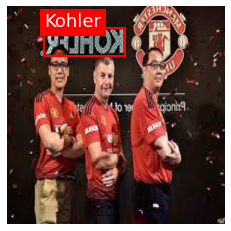

In [82]:
def Image_disp(image):  
  fig,ax=plt.subplots()
  plt.text(coord(0)+1, coord(1)-5, labels1[0]['categories'][0],fontdict={'fontsize':18.0, 'fontweight':'medium','color': 'white', 'backgroundcolor':'red'})
  bb = patch.Rectangle((coord(0), coord(1)), coord(2), coord(3), linewidth=2, edgecolor='red', facecolor='none')
  ax.add_patch(bb)
  ax.axis('off')
  ax.imshow(image.permute(1,2,0))
  plt.show()
Image_disp(images)

In [83]:
config = [
    (32, 3, 1),
    (64, 3, 2),
    ["B", 1],
    (128, 3, 2),
    ["B", 2],
    (256, 3, 2),
    ["B", 8],
    (512, 3, 2),
    ["B", 8],
    (1024, 3, 2),
    ["B", 4],  # To this point is Darknet-53
    (512, 1, 1),
    (1024, 3, 1),
    "S",
    (256, 1, 1),
    "U",
    (256, 1, 1),
    (512, 3, 1),
    "S",
    (128, 1, 1),
    "U",
    (128, 1, 1),
    (256, 3, 1),
    "S",]
import torch.nn as nn
class CNN(nn.Module):
  def __init__(self,in_ch,out_ch,batch_norm=True, **kwargs):
    super().__init__()
    self.conv_layer=nn.Conv2d(in_ch,out_ch,bias=not batch_norm, **kwargs)
    self.batch_norm=nn.BatchNorm2d(out_ch)
    self.activation=nn.LeakyReLU(0.1)
  def forward(self,im):
    return self.activation(self.batch_norm(self.conv_layer(im))) if self.batch_norm else self.activation(self.conv_layer(im))
class Resnets(nn.Module):
  def __init__(self,in_ch,repeats=1,use=True):
    super().__init__()
    self.res_layer=nn.ModuleList()
    self.use=use
    self.repeats=repeats
    for i in range(repeats):
      self.res_layer+=[nn.Sequential(CNN(in_ch, in_ch // 2, kernel_size=1),
                    CNN(in_ch// 2, in_ch, kernel_size=3, padding=1))]
  def forward(self,im):
    for i in self.res_layer:
      im=im+i(im) if self.use else i(im)
    return im
class Preds(nn.Module):
  def __init__(self, in_ch, labels):
    super().__init__()
    self.pred_layers=nn.Sequential(
            CNN(in_ch, 2 * in_ch, kernel_size=3, padding=1),
            CNN(2 * in_ch, (num_classes + 5) * 3, batch_norm=False, kernel_size=1))
    self.num_labels=labels
  def forward(self,im):
    reshaped_sample=self.pred_layers(im).reshape(im.shape[0],3,self.num_labels+5,im.shape[2],im.shape[3])
    sample=reshaped_sample.permute(0,1,3,4,2)
    return sample
class Comb_Model(nn.Module):
    def __init__(self, in_channels=3, num_classes=80):
        super().__init__()
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.layers = self._create_conv_layers()

    def forward(self, x):
        outputs = []  # for each scale
        route_connections = []
        for layer in self.layers:
            if isinstance(layer, Preds):
                outputs.append(layer(x))
                continue
            x = layer(x)

            if isinstance(layer, Resnets) and layer.repeats == 8:
                route_connections.append(x)

            elif isinstance(layer, nn.Upsample):
                x = torch.cat([x, route_connections[-1]], dim=1)
                route_connections.pop()

        return outputs

    def _create_conv_layers(self):
        layers = nn.ModuleList()
        in_channels = self.in_channels

        for module in config:
            if isinstance(module, tuple):
                out_channels, kernel_size, stride = module
                layers.append(
                    CNN(
                        in_channels,
                        out_channels,
                        kernel_size=kernel_size,
                        stride=stride,
                        padding=1 if kernel_size == 3 else 0,
                    )
                )
                in_channels = out_channels

            elif isinstance(module, list):
                num_repeats = module[1]
                layers.append(Resnets(in_channels, repeats=num_repeats,))

            elif isinstance(module, str):
                if module == "S":
                    layers += [
                        Resnets(in_channels, use=False, repeats=1),
                        CNN(in_channels, in_channels // 2, kernel_size=1),
                        Preds(in_channels // 2, labels=self.num_classes),
                    ]
                    in_channels = in_channels // 2

                elif module == "U":
                    layers.append(nn.Upsample(scale_factor=2),)
                    in_channels = in_channels * 3

        return layers



num_classes = 30
IMAGE_SIZE = 640
model = Comb_Model(num_classes=num_classes)
print(model._create_conv_layers())
x = torch.randn((2, 3, IMAGE_SIZE, IMAGE_SIZE))
out = model(x)
assert model(x)[0].shape == (2, 3, IMAGE_SIZE//32, IMAGE_SIZE//32, num_classes + 5)
assert model(x)[1].shape == (2, 3, IMAGE_SIZE//16, IMAGE_SIZE//16, num_classes + 5)
assert model(x)[2].shape == (2, 3, IMAGE_SIZE//8, IMAGE_SIZE//8, num_classes + 5)
print("Success!")

ModuleList(
  (0): CNN(
    (conv_layer): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.1)
  )
  (1): CNN(
    (conv_layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (batch_norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation): LeakyReLU(negative_slope=0.1)
  )
  (2): Resnets(
    (res_layer): ModuleList(
      (0): Sequential(
        (0): CNN(
          (conv_layer): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (batch_norm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (activation): LeakyReLU(negative_slope=0.1)
        )
        (1): CNN(
          (conv_layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (ba